# Important: 
## To successfully execute this notebook prior codes according to the flow chart needs to be run so that data is generated

In [1]:
import pandas as pd
import numpy as np
import os
import re
import pickle
import pprint
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import sobol
import sympy as sym
import matplotlib.ticker as ticker
import scipy

In [2]:
file_list=pd.read_csv('file_list.txt',header=None).iloc[:,0].to_list()
paths=[]
for i in file_list:
    temp=re.search(r'[A-D]+_P\d',i).group()
    if temp not in paths:
        paths.append(temp)
    del temp
paths=sorted(paths,key=lambda x:(len(re.search(r'[A-D]+',x).group()),re.search(r'[A-D]+_P\d',x).group()))
file_list=sorted(file_list,key=lambda x:(len(re.search(r'[A-D]+',x).group()),re.search(r'[A-D]+_P\d',x).group(),int(re.search(r'_\d+',x).group()[1:])))

In [3]:
scan_data=pd.read_csv('scan_result.csv',index_col=0)
try:
    scan_data.drop(['turing_accept','turing_a_count'],axis=1,inplace=True)
except:
    pass
print('All parameter sets:',scan_data.shape[0],'\nTuring parameter sets:',scan_data.turing.sum())

All parameter sets: 7 
Turing parameter sets: 6


## Filter Dispersion parameter sets
This code section filters dispersion parameters sets according to predefine conditions and save the results in scan_result_*.csv files

In [4]:
def max_val(a):
    if len(a)==0:
        return 0
    else:
        return np.max(a)
#----------------------------- 
def min_val(a):
    if len(a)==0:
        return 0
    else:
        return np.min(a)
#-----------------------------
def perf_avg(a):
    if len(a)==0:
        return 0
    else:
        return np.mean(a)

In [5]:
def filter_disp_scan():
    for dec_variable in ['average','stringent']: # set 'average' for using average as the condition and 'stringent' for the stringent condition
        turing_accept=[];turing_accept_count=[]
        if dec_variable not in os.listdir('data_disp_all_path'):
            os.mkdir('data_disp_all_path/'+dec_variable)
    #----------------------------- 
        for k in scan_data.index:
            index=(scan_data.loc[k,'ode_id'])
            if (scan_data.loc[k,'turing'])==0:
                turing_accept.append(0)
                turing_accept_count.append(0)
            else:
                df_temp=pd.read_csv('data_disp_all_path/'+index+'.csv',index_col=0)
                df_temp.drop('accept',axis=1,inplace=True)       
                df_diff=df_temp.iloc[:,1+int((df_temp.shape[-1]-1)/2):].copy()
            #-----------------------------  
                accept=[]
                for i in df_diff.index:
                    one_comp=[]
                    two_comp=[]
                    three_comp=[]
                    four_comp=[]
                    for j in df_diff.columns:
                        if len(j)==3:
                            one_comp.append(df_diff[j][i])
                        if len(j)==4:
                            two_comp.append(df_diff[j][i])
                        if len(j)==5:
                            three_comp.append(df_diff[j][i])
                        if len(j)==6:
                            four_comp.append(df_diff[j][i])
                    tempo_max_0=[max_val(one_comp),max_val(two_comp),max_val(three_comp),max_val(four_comp)]
                    tempo_min_0=[min_val(one_comp),min_val(two_comp),min_val(three_comp),min_val(four_comp)]
                    avg_list_0=[perf_avg(one_comp),perf_avg(two_comp),perf_avg(three_comp),perf_avg(four_comp)]
                    tempo_max = [i for i in tempo_max_0 if i != 0]  
                    tempo_min = [i for i in tempo_min_0 if i != 0]  
                    avg_list = [i for i in avg_list_0 if i != 0]
                    decision=[]
                    if dec_variable=='average':
                        for low,hi in zip(avg_list[:-1],avg_list[1:]):
                            if low>=hi:decision.append(1)
                            else:decision.append(0)
                    elif dec_variable=='stringent':
                        for low,hi in zip(tempo_min[:-1],tempo_max[1:]):
                            if low>=hi:decision.append(1)
                            else:decision.append(0)
                    if 0 not in decision:
                        accept.append(1)
                    else:
                        accept.append(0)
            #----------------------------- 
                df_temp.insert(loc=1,value=accept,column='accept')
                df_temp.to_csv('data_disp_all_path/'+dec_variable+'/'+index+'.csv')
                if 1 in accept:
                    turing_accept.append(1)
                    turing_accept_count.append(np.sum(accept))
                else:
                    turing_accept.append(0)
                    turing_accept_count.append(0)
        scan_data['turing_accept']=turing_accept
        scan_data['turing_accept_count']=turing_accept_count
        scan_data.to_csv('scan_result_'+dec_variable+'.csv')
filter_disp_scan()

In [6]:
scan_data_av=pd.read_csv('scan_result_average.csv',index_col=0)
scan_data_st=pd.read_csv('scan_result_stringent.csv',index_col=0)
print('Total number of parameter sets: ',scan_data_st.shape[0],\
    '\n Turing parameter sets: ',scan_data_av['turing'].sum(),\
    '\n Acceptable Turing parameter sets (average condition): ',scan_data_av.turing_accept.sum(),\
    '\n Acceptable Turing parameter sets (stringent condition): ',scan_data_st.turing_accept.sum())

Total number of parameter sets:  7 
 Turing parameter sets:  6 
 Acceptable Turing parameter sets (average condition):  3 
 Acceptable Turing parameter sets (stringent condition):  0


# Generate fortran code and run simulation

In this section we performed simulation with fortran code using the continuation and dispersion parameter values

### we have used intel fortran compiler to execute the simulate_pde_id() function...
### if you don't have access to intel fortran please install gfortran, however, the simulation will be considerably slower with gfortran compiler

In [89]:
#------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------
def simulate_pde_id(pde_id,\
    #--------------------------------------------------------------
    #                  simulation parameters
    #--------------------------------------------------------------
    d_t=0.001,
    n_time=100000,
    d_x=0.5,n_x=100,
    d_y=0.5,n_y=100,
    n_stim=20,stim_amp=0.01,spread_stim=0.5,
    # boundary_cond='periodic'
    boundary_cond='zero flux',
    grid_size=None,run_sim=1,compiler='ifortran'
             ):
    '''The function simulate_pde_id gets input of pde-id and simulation parameters
    and generate a fortran code for simulation based on explicit forward Euler algorithm and executes the code and saves all the output files insise a directory named as the given pde-id.
    important:for this function to work properly, intel fortran should be installed in the working environment
    returns: simulated pde_id (string) and time gap between snapshots (float)'''
    file_list=pd.read_csv('file_list.txt',header=None).iloc[:,0].to_list()
    scan_data=pd.read_csv('scan_result.csv',index_col=0)
    try:
        scan_data.drop(['turing_accept','turing_a_count'],axis=1,inplace=True)
    except:
        pass
    if grid_size != None:
        d_x=grid_size
        d_y=grid_size
    n_wri=int(n_time/10)
    ode_id_current=re.search(r'[A-D]+_P\d_\d+',pde_id).group()
    model=pickle.load(open('data_hb_all_paths/'+ode_id_current+'_modeldict','rb'))
    try:os.system('rm -f test.* fort.*')
    except:pass
    #--------------------------------------------------------------
    code_string=''
    code_string+=f'implicit none\n!--------------------------------------\n'
    #--------------------------------------------------------------
    #                      variable declaration
    #--------------------------------------------------------------
    free_pars={}
    df=pd.read_csv("disp_data_compiled/disp_"\
                   +re.search(r'[A-D]+_P\d',ode_id_current).group()+".csv",index_col=0)
    df.drop(['accept_stringent','accept_average'],axis=1,inplace=True)
    vall=df[df['pde_id']==pde_id].values[0]
    vall=vall[2:]
    for i0,i1 in enumerate(df.columns[2:]):
        if i0>0 and i0<1+(df.shape[-1]-3)/2:
            free_pars[i1+'_0']=vall[i0]
        elif i0>=1+(df.shape[-1]-3)/2:
            free_pars['D'+i1]=vall[i0]
        else:
            free_pars[i1]=vall[i0]
    #--------------------------------------------------------------
    if (scan_data[scan_data.ode_id==ode_id_current].turing.values[0])==0:
        print('No turing pattern available for this parameter set!!')
    else:
        for k in model['vars'].keys():
            code_string+=f'double precision,allocatable,dimension(:,:)::{k},{k}_m\n'
            code_string+=f'double precision::lap_{k},r_{k}\n'
        code_string+=f'double precision,allocatable,dimension(:,:)::r\n'    
        for k,v in model['pars'].items():
            if k!='sB':
                code_string+=f'double precision::{k}={v}\n'
        for k,v in free_pars.items():
            code_string+=f'double precision::{k}={v}\n'
        code_string+=f'double precision::d_t={d_t},d_x={d_x},d_y={d_y}\n'    
        code_string+=f'double precision::stim_amp={stim_amp},spread_stim={spread_stim},r_x,r_y\n'    
        code_string+=f'integer::i_stim,n_stim={n_stim}\n'    
        code_string+=f'integer::n_time={n_time},n_x={n_x},n_y={n_y}\n'    
        code_string+=f'integer::i,j,k_time,l,n_wri={n_wri}\n'    
        code_string+=f'!--------------------------------------\n'    
    #--------------------------------------------------------------
    #                    memory allocation
    #--------------------------------------------------------------
        for k in model['vars'].keys():
            code_string+=f'allocate({k}(n_x,n_y),{k}_m(n_x,n_y))\n'
        code_string+=f'allocate(r(n_x,n_y))! random array of size (n_x,n_y)\n'
        code_string+=f'!--------------------------------------\n'    
    #--------------------------------------------------------------
    #                   assign initial conditions
    #--------------------------------------------------------------
        code_string+=f'call random_seed\n'
        for k in model['vars'].keys():
            code_string+=f'{k}={k}_0\n'
        code_string+=f'do i_stim=1,n_stim\n'
        code_string+=f'call random_number(harvest=r_x)\n'
        code_string+=f'call random_number(harvest=r_y)\n'
        code_string+=f'r_x=(0.1*n_x*d_x)+(r_x*(d_x*(n_x-(n_x*0.2))))\n'
        code_string+=f'r_y=(0.1*n_y*d_y)+(r_y*(d_y*(n_y-(n_y*0.2))))\n'
        
        code_string+=f'do i=1,n_x\ndo j=1,n_y\n'
        for k in model['vars'].keys():
            code_string+=f'{k}(i,j)={k}(i,j)+stim_amp*exp(-(((i*d_x)-r_x)**2+((j*d_y)-r_y)**2)/(2*spread_stim))\n'
        code_string+=f'end do\nend do\nend do\n'
        code_string+=f'!--------------------------------------\n'
    #--------------------------------------------------------------
    #                   assign boundary condition
    #--------------------------------------------------------------
        if (boundary_cond[0].upper())=='Z':
            for k in model['vars'].keys():
                code_string+=f'{k}(1,:)={k}(2,:);{k}(n_x,:)={k}((n_x-1),:)\n'
                code_string+=f'{k}(:,1)={k}(:,2);{k}(:,n_y)={k}(:,n_y-1)\n'
        if (boundary_cond[0].upper())=='P':
            for k in model['vars'].keys():
                code_string+=f'{k}(1,:)={k}((n_x-1),:);{k}(n_x,:)={k}(2,:)\n'
                code_string+=f'{k}(:,1)={k}(:,(n_y-1));{k}(:,n_y)={k}(:,2)\n'
        code_string+=f'!--------------------------------------\n'
    #--------------------------------------------------------------
    #                        pde integration
    #--------------------------------------------------------------
        code_string+=f'do k_time=0,n_time\n'# time loop
        code_string+=f'!--------------------------------------\n'
    #--------------------------------------------------------------
    #                       writing files
    #--------------------------------------------------------------
        for k in model['vars'].keys():
            code_string+=f'{k}_m={k}\n'
        #-----------
        code_string+=f'if(mod(k_time,n_wri).eq.0)then\n'
        multi=2+len(model['vars'].keys())
        code_string+=f"do i=1,n_x\ndo j=1,n_x\
            \nwrite(200+(k_time/n_wri),'({multi}(2x,f12.5))')(i*d_x),(j*d_y),"
        dummy_string=''
        for i,k in enumerate(sorted(list(model['vars'].keys()),key=len)):
            if i<len(model['vars'].keys())-1:
                code_string+=f"{k}_m(i,j),"
                dummy_string+=f"{k}_m(i,j),"
            else:
                code_string+=f"{k}_m(i,j)"
                dummy_string+=f"{k}_m(i,j)"
        code_string+=f'\nend do\n'
        code_string+=f"write(200+(k_time/n_wri),*)\n"
        code_string+=f'end do\n'
        code_string+=f'end if\n'
        code_string+=f'!--------------------------------------\n'
    #--------------------------------------------------------------
        code_string+=f'do i=2,n_x-1\n'
        code_string+=f'do j=2,n_y-1\n'
        for k in model['vars'].keys():
            code_string+=f'lap_{k}=({k}_m(i+1,j)+{k}_m(i-1,j)-(2*{k}_m(i,j)))/(d_x**2)\n'
            code_string+=f'lap_{k}=lap_{k}+({k}_m(i,j+1)+{k}_m(i,j-1)-(2*{k}_m(i,j)))/(d_y**2)\n'
            code_string+=f'lap_{k}=lap_{k}*DD_{k}\n'
            code_string+=f'\n'
        for k,v in model['vars'].items(): 
            code_string+=f"r_{k}="+re.sub(r'(\*[A-Z]+)',r'\1_m(i,j)',v)+"\n"
            code_string+=f'\n'
        for k in model['vars'].keys():
            code_string+=f'{k}(i,j)={k}_m(i,j)+(d_t*(r_{k}+lap_{k}))\n'
            code_string+=f'\n'
        code_string+=f'\n'
        code_string+=f'end do\n'
        code_string+=f'end do\n'
    #--------------------------------------------------------------
    #                   assign boundary condition
    #--------------------------------------------------------------
        if (boundary_cond[0].upper())=='Z':
            for k in model['vars'].keys():
                code_string+=f'{k}(1,:)={k}(2,:);{k}(n_x,:)={k}((n_x-1),:)\n'
                code_string+=f'{k}(:,1)={k}(:,2);{k}(:,n_y)={k}(:,n_y-1)\n'
        if (boundary_cond[0].upper())=='P':
            for k in model['vars'].keys():
                code_string+=f'{k}(1,:)={k}((n_x-1),:);{k}(n_x,:)={k}(2,:)\n'
                code_string+=f'{k}(:,1)={k}(:,n_y-1);{k}(:,n_y)={k}(:,2)\n'
        code_string+=f'!--------------------------------------\n'
        code_string+=f'end do\n'# time-loop
    #--------------------------------------------------------------
    code_string+=f'!--------------------------------------\nend\n'
    lines=(code_string.split('\n'))
    len_lines=[len(i) for i in lines]
    n=130
    for i,line in enumerate(lines):
        if len(line) >n :
            for kk in range(int(len(line)/n)):
                line=line[:(((kk+1)*n)+(2*kk))]+'&\n'+line[(((kk+1)*n)+(2*kk)):]
                lines[i]=line
    code_string="\n".join(lines)
    #--------------------------------------------------------------
    with open("variables.txt","a") as file:
        file.write(dummy_string)
    with open("test.f90","a") as file:
        file.write(code_string)
    print('fortran simulation code generated succesfully!!\nrunning simulation now')
    if run_sim:
        os.system(f'rm -rf {pde_id}')
        os.mkdir(pde_id)
        # os.system('rm -f fort.* *.out && ifort test.f90 -o test.out && ./test.out & \n echo $! > pid.log')
        if compiler[0].lower()=='i':
            os.system('rm -f fort.* *.out && ifort test.f90 -o test.out')
        elif compiler[0].lower()=='g':
            os.system('rm -f fort.* *.out && gfortran test.f90 -o test.out')
        os.system(f'mv test.f90 test.out variables.txt {pde_id}/.')
        os.chdir(f'{pde_id}')
        os.system('./test.out & \n echo $! > pid.log')
        os.chdir('../')
    return pde_id,(d_t*n_time)/10
#-----------------------
#-----------------------
#-----------------------

## chose pde ids from disp_data_compiled/*.csv files

In [ ]:
## a sample simulation
## chose pde ids from disp_data_compiled/*.csv files
pde_id_sim,t_wri=simulate_pde_id(pde_id='pde id goes here'
                                ,grid_size=3.0,\
                                d_t=25e-5,n_time=4000000,\
                                spread_stim=30.0,n_stim=10,run_sim=1,compiler='ifortran')

# ABCD_P1_04843_D_27366 (used in supp data)

# AAB_P1_2561_D_21620,AAB_P1_2561_D_21669 for fig 5b and 5c respectively

In [27]:
def plot_pattern(input_file,pde_id,t_wri,set_title=0,ticks_labels=1,\
                 n_cont=20,z_col=2,c_map='RdGy_r',save_fig=False,dpi=150,v_lim=False,pattern=None):
    if input_file not in os.listdir(pde_id):
        print('file does not exist yet!!')
        return
    if pattern:
        df=pd.read_csv(f'{pde_id}/pattern/{input_file}',sep=r'\s+',header=None)
    else:
        df=pd.read_csv(f'{pde_id}/{input_file}',sep=r'\s+',header=None)
    dim=int(np.sqrt(len(df)))
    x=df.iloc[:,0].values.reshape(dim,dim)
    y=df.iloc[:,1].values.reshape(dim,dim)
    z=df.iloc[:,z_col].values.reshape(dim,dim)
    fig0,fig=plt.subplots()
    if v_lim==False:
        cs=fig.contourf(x,y,z,n_cont,cmap=c_map)
        cbar=fig0.colorbar(cs)
    else:
        cs=fig.contourf(x,y,z,n_cont,cmap=c_map,levels=np.linspace(v_lim[0],v_lim[1],400))
        cbar=fig0.colorbar(cs,ticks=np.linspace(v_lim[0],v_lim[1],6))
    if ticks_labels:
        fig.set_xlabel('X',size='11')
        fig.set_ylabel('Y',size='11')
    else:
        fig.set_xticks([])
        fig.set_yticks([])
    if set_title:
        fig.set_title(f'{pde_id} at t={t_wri*(int(input_file[-3:])-200):.1f} time units')
    if save_fig:
        if (x[1,1]-x[0,1])<2:
            plt.savefig(pde_id+'_high.png',dpi=dpi)
        else:
            plt.savefig(pde_id+'_low.png',dpi=dpi)
        # plt.savefig(pde_id+'.svg',dpi=300)
    plt.show()
    plt.close()
plot_pattern('fort.210',pde_id=pde_id_sim,t_wri=t_wri)

# Dispersion Curves and Characteristic Jacobians

sB = 15.4302


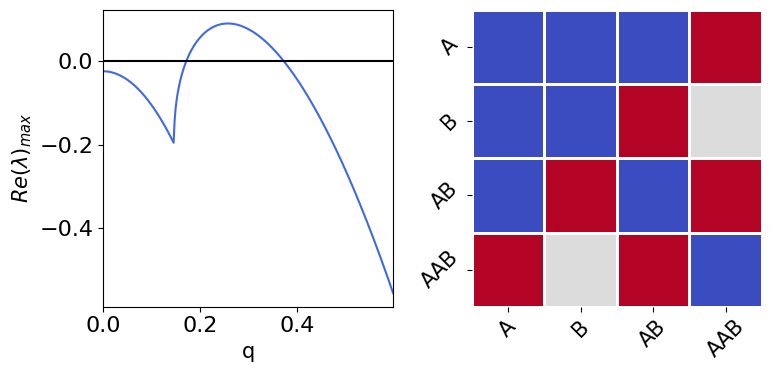

In [99]:
def get_disp_curve(pde_id,dk=0.01,k_max=10,print_pars=False,save_fig=0,scaling=0):
    import sympy as sym
    #--------------------------------------
    ode_id = re.search(r'[A-D]+_P\d_\d+',pde_id).group()
    model = pickle.load(open('model_all_paths.pickle','rb'))
    pars = model[ode_id]['pars']
    df = pd.read_csv('disp_data_compiled/disp_'+re.search(r'[A-D]+_P\d',pde_id).group()+'.csv',index_col=0)
    if pde_id in df['pde_id'].to_list():
        df = df[df['pde_id'] == pde_id].drop(['ode_id','pde_id','accept_average','accept_stringent'],axis=1).reset_index()
        print('sB = '+str(df['sB'][0]))
    else:
        print('invalid pde id!!')
        return
    #--------------------------------------
    for i in df.columns[1:]:
        pars[i] = df.loc[0,i]
    pars_list=[];pars_val=[]
    for k,v in pars.items():
        pars_list.append(k)
        pars_val.append(v)
    for i in pars.keys():
        sym.symbols(i)
    f_list = []
    vars = []
    for k in model[ode_id]['vars'].keys():
        vars.append(k)
    vars=sorted(vars,key=len)
    for i in vars:
        f_list.append(model[ode_id]['vars'][i])
    vars = sym.symbols(vars)
    f = sym.sympify(f_list)
    J0 = sym.zeros(len(f),len(vars))
    for i, fi in enumerate(f):
        for j, s in enumerate(vars):
            J0[i,j] = sym.diff(fi, s)
    jac_gen_func=sym.lambdify([tuple(pars_list)],J0,'numpy')
    J=jac_gen_func(tuple(pars_val))
    ks=np.arange(0,k_max,dk)
    temp=df.values[0][2:]
    D=np.diag(temp[int(len(temp)/2):])
    disp_curve=[]
    for k in ks:
        J_mod=J-(D*k**2)
        disp_curve.append(np.max(np.real(np.linalg.eig(J_mod)[0])))
    #--------------------------------------
    if scaling:
        p=np.max(disp_curve)-disp_curve[0]
        disp_curve=disp_curve-disp_curve[0]-(0.5*p)
        disp_curve_ajd_mul=disp_curve[:-1]*disp_curve[1:]
        intersect_1=np.where(disp_curve_ajd_mul<0)[0][0]
        ks=ks/ks[intersect_1]
    #--------------------------------------
    if disp_curve[0]>0:
        color='darkred'
    else:
        color='royalblue'
    #--------------------------------------
    fig,(ax1,ax2)=plt.subplots(1,2,)
    fig.set_figwidth(10)
    fig.set_figheight(5)
    ax1.plot(ks,disp_curve,c=color,)
    ax1.plot(ks,np.zeros(len(ks)),c='k')
    ax1.set_xlabel('q',size='15')
    ax1.set_ylabel(r'$Re(\lambda)_{max}$',size='15')
    ax1.set_xlim(0,np.max(ks))
    #-------------------------------------
    sns.heatmap(np.sign(J),ax=ax2,linecolor='white',linewidth=1.0,cmap='coolwarm',center=0,cbar=False)
    ax2.set_xticks(np.arange(J.shape[1]) + 0.5, minor=False)
    ax2.set_yticks(np.arange(J.shape[0]) + 0.5, minor=False)
    ticks=df.columns[2:int(2+(df.shape[-1]-2)/2)].to_numpy()
    ax2.set_xticklabels(ticks,rotation =45,size=15)
    ax2.set_yticklabels(ticks,rotation =45,size=15)
    #-------------------------------------
    fig.set_figheight(4)
    fig.set_figwidth(8)
    # fig.suptitle(re.sub('_','-',pde_id))
    #-------------------------------------
    plt.tight_layout()
    plt.close()
    if print_pars:
        pprint.pprint(pars)
    if save_fig:
        fig.figure.savefig(f'dispersion_{pde_id}.png',dpi=600)
        fig.figure.savefig(f'dispersion_{pde_id}.svg',dpi=300)
    #-------------------------------------
    # display(J0)
    return fig
disp_curve=get_disp_curve(pde_id='pde id goes here'\
                                   ,k_max=0.6,dk=0.001,print_pars=0,scaling=0,save_fig=1)
disp_curve.get_figure()

## Dispersion data analysis

### Confirmation of type-1 dispersion

file already exists!!!


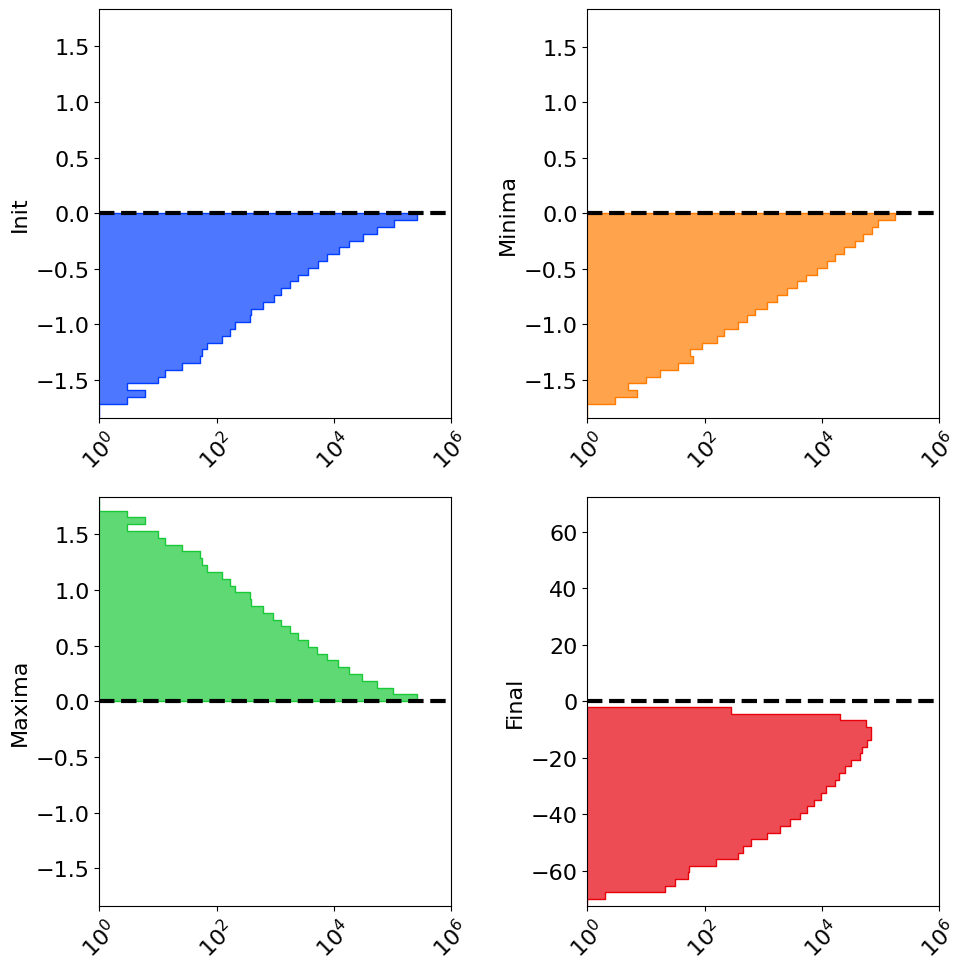

In [98]:
def get_disp_data(pde_id,dk=0.01,k_max=10,scaling=0):  
    '''Generates dispersion data and returns two lists:
    disp_curve and wave numbers'''
    #--------------------------------------
    ode_id = re.search(r'[A-D]+_P\d_\d+',pde_id).group()
    model = pickle.load(open('model_all_paths.pickle','rb'))
    pars = model[ode_id]['pars']
    df = pd.read_csv('disp_data_compiled/disp_'+re.search(r'[A-D]+_P\d',pde_id).group()+'.csv',index_col=0)
    if pde_id in df['pde_id'].to_list():
        df = df[df['pde_id'] == pde_id].drop(['ode_id','pde_id','accept_average','accept_stringent'],axis=1).reset_index()
    else:
        print('invalid pde id!!')
        return
    #--------------------------------------
    for i in df.columns[1:]:
        pars[i] = df.loc[0,i]
    pars_list=[];pars_val=[]
    for k,v in pars.items():
        pars_list.append(k)
        pars_val.append(v)
    for i in pars.keys():
        sym.symbols(i)
    f_list = []
    vars = []
    for k in model[ode_id]['vars'].keys():
        vars.append(k)
    vars=sorted(vars,key=len)
    for i in vars:
        f_list.append(model[ode_id]['vars'][i])
    vars = sym.symbols(vars)
    f = sym.sympify(f_list)
    J0 = sym.zeros(len(f),len(vars))
    for i, fi in enumerate(f):
        for j, s in enumerate(vars):
            J0[i,j] = sym.diff(fi, s)
    jac_gen_func=sym.lambdify([tuple(pars_list)],J0,'numpy')
    J=jac_gen_func(tuple(pars_val))
    ks=np.arange(0,k_max,dk)
    temp=df.values[0][2:]
    D=np.diag(temp[int(len(temp)/2):])
    disp_curve=[]
    for k in ks:
        J_mod=J-(D*k**2)
        disp_curve.append(np.max(np.real(np.linalg.eig(J_mod)[0])))
    #--------------------------------------
    if scaling:
        p=np.max(disp_curve)-disp_curve[0]
        disp_curve=disp_curve-disp_curve[0]-(0.5*p)
        disp_curve_ajd_mul=disp_curve[:-1]*disp_curve[1:]
        try:
            intersect_1=np.where(disp_curve_ajd_mul<0)[0][0]
        except:
            intersect_1=0
        if intersect_1!=0:
            ks=ks/ks[intersect_1]
        else:
            return [],0,[],0
    detector=(disp_curve[1:-1]-disp_curve[:-2])*(disp_curve[1:-1]-disp_curve[2:])
    points=disp_curve[np.where(detector>0)]
    if len(points)==1:
        points=np.insert(points,0,disp_curve[0])
    points=np.insert(points,0,disp_curve[0])
    points=np.insert(points,points.size,disp_curve[-1])
    return points,intersect_1,disp_curve,ks
#--------------------------------------------------------
#--------------------------------------------------------
#--------------------------------------------------------
def collect_disp_points(sample_size=20):
    paths=sorted(sorted(list(set([re.match(r'[A-D]+_P\d',s).group()\
                             for s in os.listdir('data_hb_all_paths')]))),key=len)
    os.system('rm -f disp_data_compiled/*.png')
    if "dispersion_points_1.csv" in os.listdir():
        print('file already exists!!!')
        return
    f=open("dispersion_points_1.csv","w")
    f.write("pde_id,init,minima,maxima,final\n")
    for path in paths:
        df=pd.read_csv(f'disp_data_compiled/disp_{path}.csv',index_col=0)
        if sample_size=='all':
            pde_id_list=df['pde_id'].to_list()
        else:
            pde_id_list=df['pde_id'].sample(sample_size).to_list()
        for i in pde_id_list:
            fetched_points,intersect,_,_=get_disp_data(pde_id=i\
                                       ,k_max=2.0,dk=0.01,scaling=1)
            if intersect!=0:
                s=i+","
                for l in fetched_points:
                    s+=str(l)+","
                s=s[:-1]
                f.write(s+"\n")
#--------------------------------------------------------
#--------------------------------------------------------
#--------------------------------------------------------
def plot_hist():
    plt.rcParams.update({'font.size': 16})
    df=pd.read_csv("dispersion_points_1.csv",on_bad_lines='skip',header=0)
    df.drop(df[(df['maxima']<0) | (df['minima']>0)].index,inplace=True)
    df.reset_index(drop=True,inplace=True)
    n_bins=30
    # display(df)
    fig,axs=plt.subplots(nrows=2,ncols=2, figsize=(10,10))
    colors=sns.color_palette("bright")
    for ax,i,c in zip(axs.flat,df.columns[1:],colors[:4]):
        sns.histplot(ax=ax,y=df[i],bins=n_bins,color=c,element='step',alpha=0.7)
        ax.set_ylabel(i.capitalize())
        ax.set_xlabel("")
        ax.set_xscale('log')
        ax.axhline(y = 0.0, color = 'k', linestyle = '--',linewidth=3)
        if i !="maxima":
            ax.set_ylim([df[i].min(),df[i].min()*-1])
        else:
            ax.set_ylim([df[i].max()*-1,df[i].max()])
        ax.set_xlim([1,1e6])
        # ax.set_title()
        plt.xticks(rotation=30)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        plt.tight_layout()
        # ax.xaxis.set_major_formatter(ticker.EngFormatter())
    plt.savefig("disp_hist/dispersion_bar_plot.svg",dpi=300)
    plt.savefig("disp_hist/dispersion_bar_plot.png",dpi=300)
    df.to_csv("dispersion_points_modified.csv")
    plt.tight_layout()
    plt.show()
#--------------------------------------------------------
#--------------------------------------------------------
collect_disp_points(sample_size='all')
plot_hist()

## Histogram plot for dispersion data

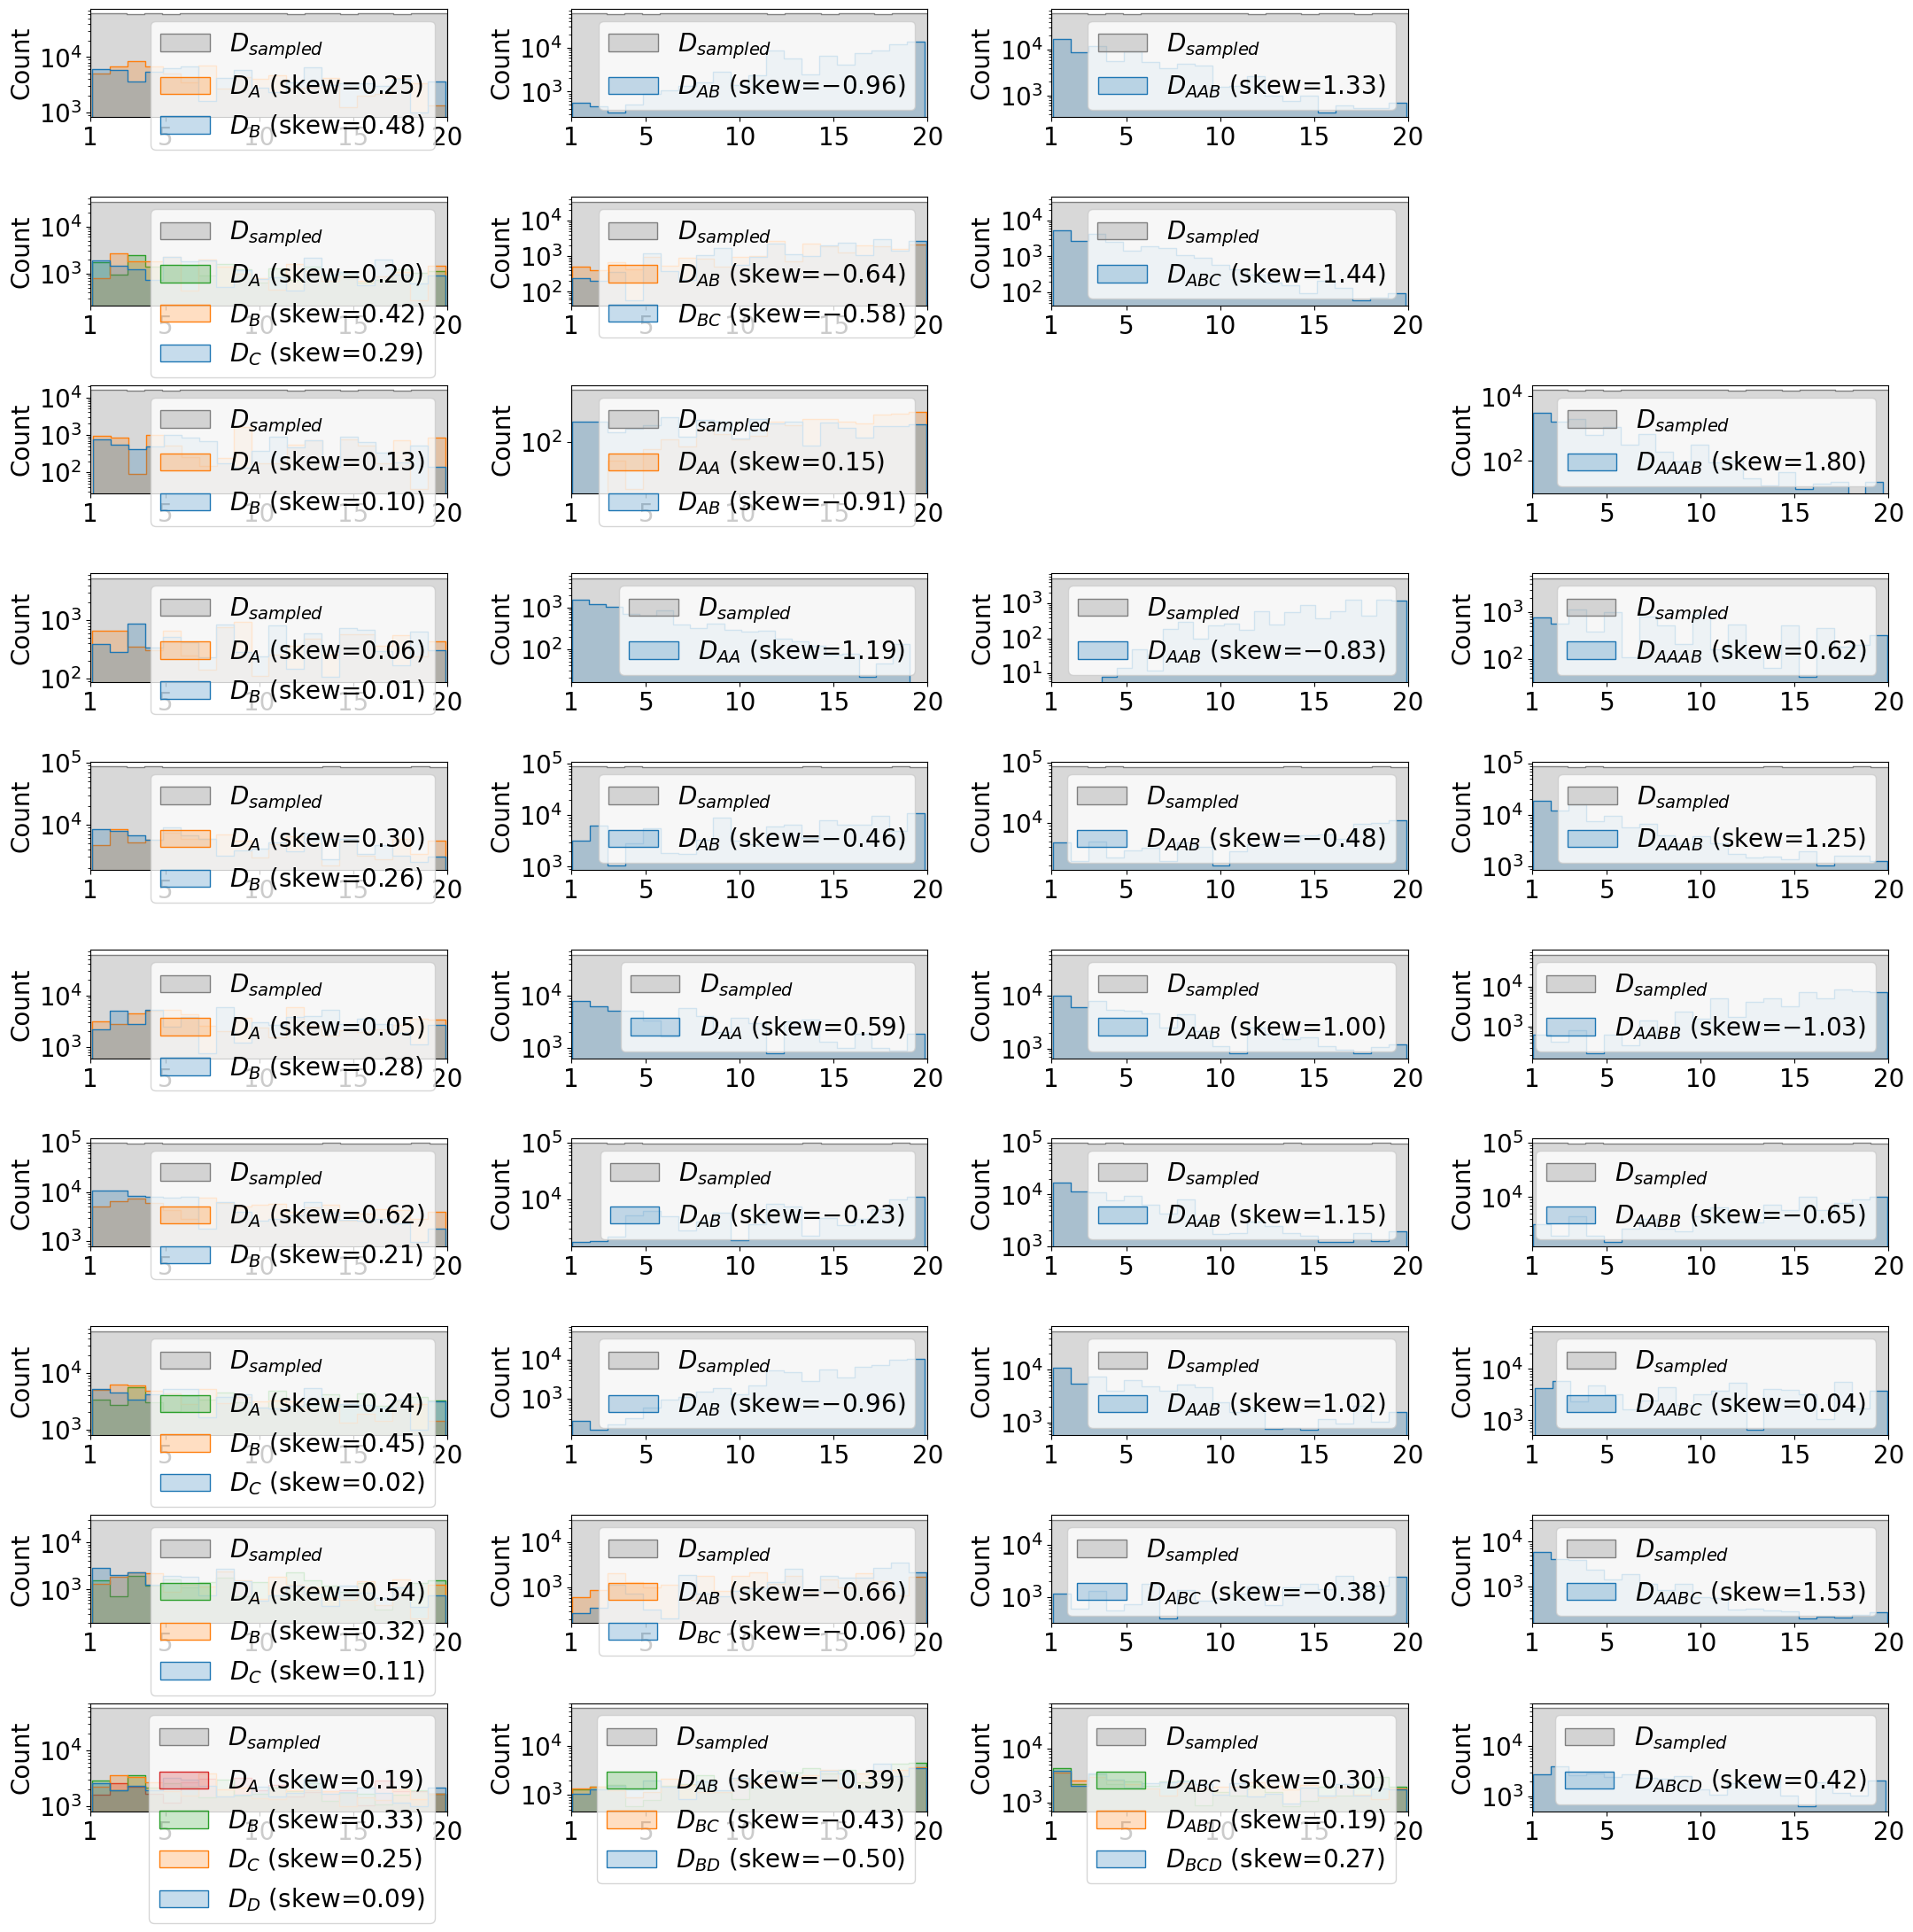

In [97]:
def disp_hist2(save_fig=0):
    paths=sorted(sorted(list(set([re.match(r'[A-D]+_P\d',s).group()\
                             for s in os.listdir('data_hb_all_paths')]))),key=len)
    plt.rcParams.update({'font.size': 20})
    fig,axs=plt.subplots(10,4,figsize=(22,22))
    for i,path in enumerate(paths):
        df_0=pd.read_csv(f"disp_data_compiled/disp_{path}.csv",index_col=0)
        df=df_0.filter(regex=r'D_[A-D]+')
        ode_id=(sorted(list(set(df_0['ode_id']))))
        d_sampled=sobol.sample(dimension=1,n_points=4000)
        d_sampled=d_sampled.flatten()
        d_sampled=1+(19*d_sampled)
        d_sampled=np.repeat(d_sampled,len(ode_id))
        for j in range(4):
            ll=len(df.columns[df.columns.str.len()==j+3])
            if ll>0:
                n_bins=20
                sns.histplot(data=d_sampled,ax=axs[i,j],bins=n_bins,element='step',color="grey",alpha=0.3)
                sns.histplot(data=df[df.columns[df.columns.str.len()==j+3]],ax=axs[i,j],bins=n_bins,element='step')
                legends_0=df.columns[df.columns.str.len()==j+3].to_list()
                legends=[re.sub(r'D_([A-D]+)',r'$D_{\1}$',i) for i in legends_0]
                legends=[(i+f" (skew=${df[j].skew():4.2f}$)") for i,j in zip(legends,legends_0)]
                legends.insert(0,r"$D_{sampled}$")
                axs[i,j].legend(legends)
                formatter = ticker.ScalarFormatter(useMathText=True)
                formatter.set_scientific(True) 
                formatter.set_powerlimits((-1,1)) 
                axs[i,j].yaxis.set_major_formatter(formatter) 
                axs[i,j].set_xlim([1,20])
                axs[i,j].set_yscale('log')
                xticks=[1,5,10,15,20]
                axs[i,j].set_xticks(xticks)
            else:
                fig.delaxes(axs[i,j])
        # break
    plt.tight_layout()
    if save_fig:
        plt.savefig("disp_hist/compiled.svg",dpi=300)
        plt.savefig("disp_hist/compiled.png",dpi=300)
    plt.show()
disp_hist2(save_fig=1)

### clustermap using skewness of histoframs of dispersion parameters

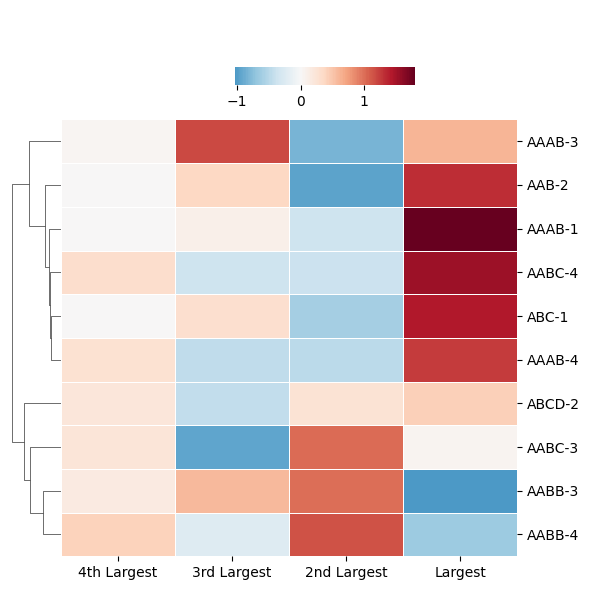

In [96]:
def fun_hm_cluster(save_fig=0):
    plt.rcParams.update({'font.size': 10})
    paths=sorted(sorted(list(set([re.match(r'[A-D]+_P\d',s).group()\
                             for s in os.listdir('data_hb_all_paths')]))),key=len)
    paths_1=[re.sub(r'_P\d+',lambda x:"-"+str(int(x.group()[2:])+1),i) for i in paths]
    comp=['4th Largest','3rd Largest','2nd Largest','Largest']
    array=[]
    for path in paths:
        df=pd.read_csv(f"disp_data_compiled/disp_{path}.csv",index_col=0)
        df=df.filter(regex=r'D_[A-D]+')
        row=[]
        for i,j in enumerate(comp):
            ll=len(df.columns[df.columns.str.len()==i+3])
            if ll>0:
                data=df[df.columns[df.columns.str.len()==i+3]]
                s=data.skew().mean()
            else:
                s=0
            row.append(s)
        array.append(row)
        # break
    array_0=np.array(array)
    array_00=np.array(array)
    for i in range(array_0.shape[0]-1):
        for j in range(array_0.shape[-1]-1,0,-1):
            if array_0[i,j]==0:
                array_0[i,1:j+1]=array_0[i,:j]
                array_0[i,0]=0
    array_df_0=pd.DataFrame(array_0,index=paths_1,columns=comp)
    array=np.array(array)
    for i in range(array.shape[0]-1):
        for j in range(array.shape[-1]-1,0,-1):
            if array[i,j]==0:
                array[i,1:j+1]=array[i,:j]
    array=array[:,[-2,-1]]
    array_df=pd.DataFrame(array,index=paths_1,columns=['n_prime','n'])
    z=scipy.cluster.hierarchy.linkage(array_df)
    fig=sns.clustermap(array_df_0,figsize=(6,6),col_cluster=0,cmap='RdBu_r',center=0,row_linkage=z, linewidths=0.5, linecolor='white',cbar_kws={"orientation": "horizontal"},cbar_pos=(0.4, 0.85,  0.3,0.03),dendrogram_ratio=(0.1,0.2))
    # fig.ax_heatmap.yaxis.tick_left()
    if save_fig:
        plt.savefig("disp_hist/heatmap.svg",dpi=300)
        plt.savefig("disp_hist/heatmap.png",dpi=300)
    # plt.close()
fun_hm_cluster(save_fig=1)